<a href="https://colab.research.google.com/github/baotram153/Reinforcement-Learning/blob/main/notebooks/On_policy_Control_with_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ON POLICY CONTROL WITH APPROXIMATION

In [ ]:
! pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.4 MB/s eta 0:00:00


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import gymnasium as gym

In [ ]:
class Utils:
    def __init__(self):
        pass
    def exhaustive_zip(self,list1, list2):
        result = [np.array([list1[i], list2[j]]) for i in range(len(list1)) for j in range(len(list2))]
        return np.array(result)
utils = Utils()

## 1. Mountain Car

### 1.1  Set up Environment, Agent and Value Function

In [ ]:
env = gym.make('MountainCar-v0')
done = False                            # check if the episode terminated
observation, info = env.reset()         # initial [position, velocity]
# print(observation)

In [ ]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [ ]:
class Tiling:           # tiling class implement following Sutton's tiles3
    def __init__    (
        self,
        n_tilings,
        n_tiles,
        state_size,
        max_size = 4096
    ) -> None: # state_size = (x_size, y_size)

        self.iht = IHT(max_size)
        self.n_tilings = n_tilings
        self.n_tiles = n_tiles
        self.max_size = max_size
        self.x_size, self.y_size = state_size
        self.x_scale_factor = self.n_tiles / self.x_size
        self.y_scale_factor = self.n_tiles / self.y_size
        self.params = np.zeros(max_size)

    def get_indices (self, state, action):
        x, y = state
        return tiles(self.iht, self.n_tilings, [x*self.x_scale_factor, y*self.y_scale_factor], [action])

    def update      (self, state, action, delta, alpha):    # alpha belong to algorithm, delta is update amount
        for index in self.get_indices(state, action):
            self.params[index] += alpha*delta

    def get_value   (self, state, action):
        state_value = 0
        for index in self.get_indices(state, action):
            state_value += self.params[index]
        return state_value

In [ ]:
class MountainCarAgent:
    def __init__    (
        self,
        value_func,
        alpha,
        gamma,
        epsilon
    ) -> None:
        self.alpha = alpha
        self.gamma = gamma
        self.value_func = value_func
        self.epsilon = epsilon

    def get_q_value (self, state, action):
        q_value = self.value_func.get_value(state, action)
        if (q_value):
            return q_value
        else:
            return 0    # Nontype

    def get_action  (self, state):     # 3 actions from 0->2 {accelerate to left, not accelerate, accelerate to right}
        if (np.random.rand() < self.epsilon):
            action = env.action_space.sample()
        else:
            action_values = []
            for action in range(env.action_space.n):
                action_values.append(self.get_q_value(state, action))
            if (np.array(action_values).all() == 0): action = env.action_space.sample()
            else:
                action = np.argmax(action_values)
        return action


    def update(self, state, action,error, ):
        self.value_func.update(state, action, error, self.alpha)

### 1.2  Episodic semi gradient algorithm

In [ ]:
# episodic semi gradient
def ep_semigrad_nsteps_Sarsa(n_eps, n_steps, alpha, gamma, epsilon):    # estimate value function of optimal policy
    value_func = Tiling(8, 8, (0.6 + 1.2, 0.07 + 0.07))
    agent = MountainCarAgent(value_func, alpha, gamma, epsilon)
    y = []
    for eps in range(n_eps):
        first_state, info = env.reset()
        states = [first_state]
        actions = [agent.get_action(first_state)]
        rewards = [0]
        T = np.infty
        t = 0
        while True:
            if (t < T):
                new_state, reward, terminated, truncated, info = env.step(actions[-1])
                states.append(new_state)
                rewards.append(reward)
                if (terminated):
                    T = t + 1
                else:
                    actions.append(agent.get_action(new_state))
            tau = t - n_steps + 1
            if (tau >= 0):
                end_bootstrap_timestep = min(T, tau + n_steps)
                return_n = 0
                for (i, idx) in enumerate (range(tau + 1, end_bootstrap_timestep + 1)):
                    return_n += gamma**i*rewards[idx]
                if (tau + n_steps < T):
                    return_n += gamma**(n_steps - 1)*agent.get_q_value(states[end_bootstrap_timestep], actions[end_bootstrap_timestep])
                error = return_n - agent.get_q_value(states[tau], actions[tau])
                agent.update(states[tau], actions[tau], error)
            if (tau == (T - 1)):
                break
            t += 1
        # if (eps % (n_eps / 5) == 0):
        #     print(f"Episode {eps} step num: {T}")
        y.append(T)
        # print(f"Params {agent.value_func.params}")
    return y

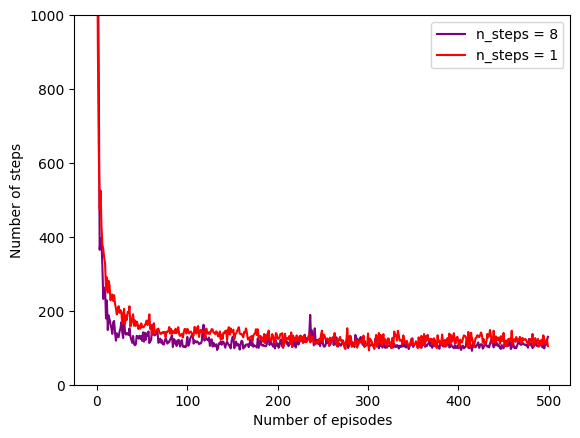

In [ ]:
n_eps = 500
y1 = []
y2 = []

for i in range(5):
    y1.append(ep_semigrad_nsteps_Sarsa(n_eps, n_steps = 8, alpha = 0.3/8, gamma = 1, epsilon = 0))
    y2.append(ep_semigrad_nsteps_Sarsa(n_eps, n_steps = 1, alpha = 0.5/8, gamma = 1, epsilon = 0))
plt.plot(range(n_eps), np.array(y1).mean(axis = 0), color = 'purple')
plt.plot(range(n_eps), np.array(y2).mean(axis = 0), color = 'red')
plt.ylim(0, 1000)
plt.xlabel("Number of episodes")
plt.ylabel("Number of steps")
plt.legend(["n_steps = 8", "n_steps = 1"])
plt.show()

## 2. Access Control Queuing Task

In [ ]:
# differential Semi-gradient Sarsa
# solved as a Tabular method
class ACQEnvironment:
    # the queue is never empty and propability of priorities is uniformly distributed
    def __init__(self, n_max_servers, priorities) -> None:
        self.server_space = range(0, n_max_servers + 1)      # num of free servers
        self.priority_space = priorities    # arr of priorities
        self.action_space = [0, 1]
        self.n_actions = 2
        self.state_space = utils.exhaustive_zip(self.server_space, self.priority_space)
        self.n_states = self.state_space.shape[0]

        self.n_max_servers = n_max_servers
        self.n_servers = n_max_servers
        self.priority = np.random.choice(priorities)

    def get_priority    (self):
        return np.random.choice(self.priority_space)

    def reset           (self):
        self.n_servers = self.n_max_servers
        self.priority = np.random.choice(self.priority_space)
        return [self.n_servers, self.priority]

    def free_servers    (self, prop):
        for _ in range(self.n_max_servers - self.n_servers):
            if (np.random.rand() < prop): self.n_servers += 1
        self.n_servers = min (self.n_servers, self.n_max_servers)

    def take_action     (self, action):
        if (action == 1):
            self.n_servers -= 1
            reward = self.priority
        else:
            reward = 0
        self.priority = np.random.choice(self.priority_space)
        return [self.n_servers, self.priority], reward

    def get_state       (self):
        return [self.n_servers, self.priority]

In [ ]:
class ACQValueFunction:
    def __init__    (self, state_space, action_space) -> None:
        # self.state_dict = enumerate(state_space)
        # print(list(self.state_dict))
        self.state_space = state_space
        self.n_states = len(state_space)
        self.params = np.zeros((self.n_states, len(action_space)))

    def get_value   (self, state, action):
        # print(list(self.state_dict))
        for idx, found_state in enumerate(self.state_space):
            if (np.array(found_state) == np.array(state)).all():
                return self.params[idx, action]

    def update      (self, state, action, delta, alpha):
        for idx, found_state in enumerate(self.state_space):
            if (found_state == state).all():
                self.params[idx, action] += alpha*delta

In [ ]:
class ACQAgent:
    def __init__    (
        self,
        value_func,
        alpha,
        epsilon
    ) -> None:
        self.alpha = alpha
        self.epsilon = epsilon
        self.value_func = value_func
        self.action_space = np.array([0, 1])          # reject / accept
        self.n_actions = self.action_space.shape[0]

    def get_q_value (self, state, action):
        q_value = self.value_func.get_value(state, action)
        if (q_value):
            return q_value
        else:
            return 0    # Nontype

    def get_action  (self, state):     # 3 actions from 0->2 {accelerate to left, not accelerate, accelerate to right}
        if (state[0] == 0): return 0   # cannot accept if there's no free server left
        if (np.random.rand() < self.epsilon):
            action = np.random.choice(self.action_space)
        else:
            action_values = []
            for action in range(self.n_actions):
                action_values.append(self.get_q_value(state, action))
            if (np.array(action_values).all() == 0): action = np.random.choice(self.action_space)
            else:
                action = np.argmax(action_values)
        # print(f"{state}, {action}")
        return action

    def update(self, state, action, error):
        self.value_func.update(state, action, error, self.alpha)

    def get_greedy_action_vector (self, state_space):
        actions = []
        for state in state_space:
            if (state[0] == 0):
                actions.append(0)
            else:
                action_values = []
                for action in range(self.n_actions):
                    print(state, action)
                    action_values.append(self.get_q_value(state, action))
                if (np.array(action_values).all() == 0):
                    actions.append(np.random.choice(self.action_space))
                    print("random")
                else:
                    actions.append(np.argmax(action_values))
                    print("not random")
        return actions

    def get_best_action_values (self, priority = 4, n_servers = 10):
        diff_values = []
        state_space = utils.exhaustive_zip(range(n_servers + 1), [priority])
        for state in state_space:
            if (state[0] == 0):
                diff_values.append(self.get_q_value(state, 0))
            else:
                action_values = []
                for action in range(self.n_actions):
                    action_values.append(self.get_q_value(state, action))
                if (np.array(action_values).all() == 0):
                    diff_values.append(0)
                else:
                    diff_values.append(np.max(action_values))
        return diff_values

In [ ]:
def diff_semi_gradient  (n_steps, alpha, beta, epsilon):
    env = ACQEnvironment(10, [0, 1, 2, 4, 8])
    value_func = ACQValueFunction(env.state_space, env.action_space)
    agent = ACQAgent(value_func, alpha, epsilon)

    avg_R = 0
    old_state = env.reset()
    old_action = agent.get_action(old_state)
    for step in range(n_steps):
        env.free_servers(prop = 0.06)
        new_state, reward = env.take_action(old_action)
        new_action = agent.get_action(new_state)
        delta = reward - avg_R + agent.get_q_value(new_state, new_action) - agent.get_q_value(old_state, old_action)
        avg_R += beta*delta
        agent.update (old_state, old_action, delta)
        old_state = new_state
        old_action = new_action
        if (step % (n_steps/10) == 0): print(f"Number of steps {step} - Current average reward: {avg_R}")
    return env, agent

In [ ]:
env, agent = diff_semi_gradient  (n_steps = 2*10**(6), alpha = 0.01, beta = 0.01, epsilon = 0.1)

Number of steps 0 - Current average reward: 0.0
Number of steps 200000 - Current average reward: 2.2344663180078976
Number of steps 400000 - Current average reward: 2.181588652444559
Number of steps 600000 - Current average reward: 2.30011424547889
Number of steps 800000 - Current average reward: 2.1560381476080837
Number of steps 1000000 - Current average reward: 2.1872221144520534
Number of steps 1200000 - Current average reward: 1.8551273812096833
Number of steps 1400000 - Current average reward: 2.290408179259046
Number of steps 1600000 - Current average reward: 2.3936225373062077
Number of steps 1800000 - Current average reward: 2.5078999089428677


[1 0] 0
[1 0] 1
not random
[1 1] 0
[1 1] 1
not random
[1 2] 0
[1 2] 1
not random
[1 4] 0
[1 4] 1
not random
[1 8] 0
[1 8] 1
not random
[2 0] 0
[2 0] 1
not random
[2 1] 0
[2 1] 1
not random
[2 2] 0
[2 2] 1
not random
[2 4] 0
[2 4] 1
not random
[2 8] 0
[2 8] 1
not random
[3 0] 0
[3 0] 1
not random
[3 1] 0
[3 1] 1
not random
[3 2] 0
[3 2] 1
not random
[3 4] 0
[3 4] 1
not random
[3 8] 0
[3 8] 1
not random
[4 0] 0
[4 0] 1
not random
[4 1] 0
[4 1] 1
not random
[4 2] 0
[4 2] 1
not random
[4 4] 0
[4 4] 1
not random
[4 8] 0
[4 8] 1
not random
[5 0] 0
[5 0] 1
not random
[5 1] 0
[5 1] 1
not random
[5 2] 0
[5 2] 1
not random
[5 4] 0
[5 4] 1
not random
[5 8] 0
[5 8] 1
not random
[6 0] 0
[6 0] 1
not random
[6 1] 0
[6 1] 1
not random
[6 2] 0
[6 2] 1
not random
[6 4] 0
[6 4] 1
not random
[6 8] 0
[6 8] 1
not random
[7 0] 0
[7 0] 1
not random
[7 1] 0
[7 1] 1
not random
[7 2] 0
[7 2] 1
not random
[7 4] 0
[7 4] 1
not random
[7 8] 0
[7 8] 1
not random
[8 0] 0
[8 0] 1
not random
[8 1] 0
[8 1] 1
not random
[

Text(50.722222222222214, 0.5, 'Priority')

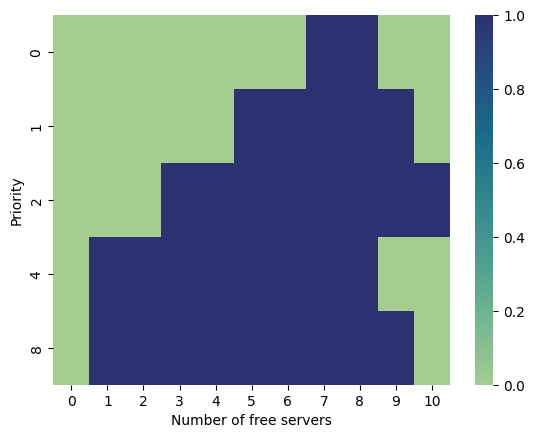

In [ ]:
import seaborn as sns

policy = np.array(agent.get_greedy_action_vector(env.state_space))
policy = np.transpose(policy.reshape(11,5))
# print(policy)d

fig = sns.heatmap(policy , cmap="crest", xticklabels=range(11), yticklabels=[0, 1, 2, 4, 8])
fig.set_xlabel('Number of free servers')
fig.set_ylabel('Priority')


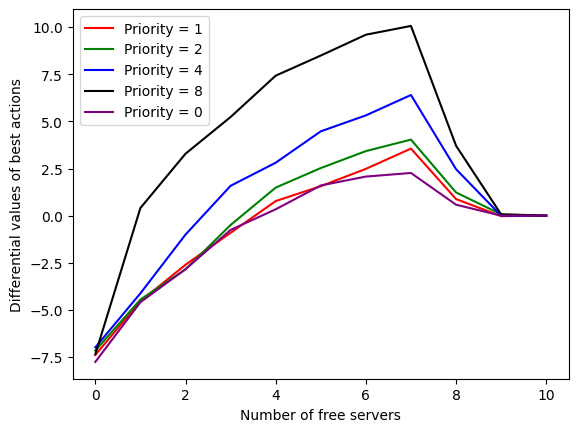

In [ ]:
diff_values4 = agent.get_best_action_values(priority = 4)
diff_values8 = agent.get_best_action_values(priority = 8)
diff_values1 = agent.get_best_action_values(priority = 1)
diff_values2 = agent.get_best_action_values(priority = 2)
diff_values0 = agent.get_best_action_values(priority = 0)
plt.plot(range(11), diff_values1, color = 'red')
plt.plot(range(11), diff_values2, color = 'green')
plt.plot(range(11), diff_values4, color = 'blue')
plt.plot(range(11), diff_values8, color = 'black')
plt.plot(range(11), diff_values0, color = 'purple')
plt.xlabel("Number of free servers")
plt.ylabel("Differential values of best actions")
plt.legend(["Priority = 1", "Priority = 2", "Priority = 4", "Priority = 8", "Priority = 0"])
plt.show()